<a href="https://colab.research.google.com/github/2021-FIIT-Bc-projects/BP-Fagan-CNN-Huby/blob/main/Experiment_3_FINAL_EfficientNetB1_8vs8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importovanie potrebných knižníc a nástrojov

In [ ]:
import matplotlib.pyplot as plt
import pathlib
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

### Pripojenie Google disku pre načítanie datasetov

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Skopírovanie datasetov a zadefinovanie ciest k nim

In [ ]:
TRAIN_DATA_DIR_GDRIVE = '/content/drive/MyDrive/Colab Notebooks/train_8vs8'
VALIDATION_DATA_DIR_GDRIVE = '/content/drive/MyDrive/Colab Notebooks/validation_8vs8'
TEST_DATA_DIR_GDRIVE = '/content/drive/MyDrive/Colab Notebooks/test_8vs8'

In [ ]:
!cp -r "$TRAIN_DATA_DIR_GDRIVE" .
!cp -r "$VALIDATION_DATA_DIR_GDRIVE" .
!cp -r "$TEST_DATA_DIR_GDRIVE" .

In [ ]:
TRAIN_DATA_DIR = './train_8vs8'
VALIDATION_DATA_DIR = './validation_8vs8'
TEST_DATA_DIR = './test_8vs8'

TRAIN_DATASET_PATH = pathlib.Path(TRAIN_DATA_DIR)
VALIDATION_DATASET_PATH = pathlib.Path(VALIDATION_DATA_DIR)
TEST_DATASET_PATH = pathlib.Path(TEST_DATA_DIR)

### Vytvorenie ImageDataGenerator-ov, ktoré slúžia pre načítanie, predspracovanie a augmentáciu obrázkov

In [ ]:
train_validation_datagen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True)

test_datagen = ImageDataGenerator()

In [ ]:
BATCH_SIZE = 64
IMG_SIZE = (240, 240)

train_dataset = train_validation_datagen.flow_from_directory(
    TRAIN_DATASET_PATH, 
    target_size=IMG_SIZE, 
    class_mode='categorical', 
    batch_size=BATCH_SIZE, 
    shuffle=True
)

validation_dataset = test_datagen.flow_from_directory(
    VALIDATION_DATASET_PATH, 
    target_size=IMG_SIZE, 
    class_mode='categorical', 
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataset = test_datagen.flow_from_directory(
      TEST_DATASET_PATH, 
      target_size=IMG_SIZE, 
      class_mode='categorical', 
      batch_size=BATCH_SIZE, 
      shuffle=False
)

Found 2876 images belonging to 16 classes.
Found 363 images belonging to 16 classes.
Found 363 images belonging to 16 classes.


### Vykreslenie augmentovaných trenovacích obrázkov

Found 2876 images belonging to 16 classes.


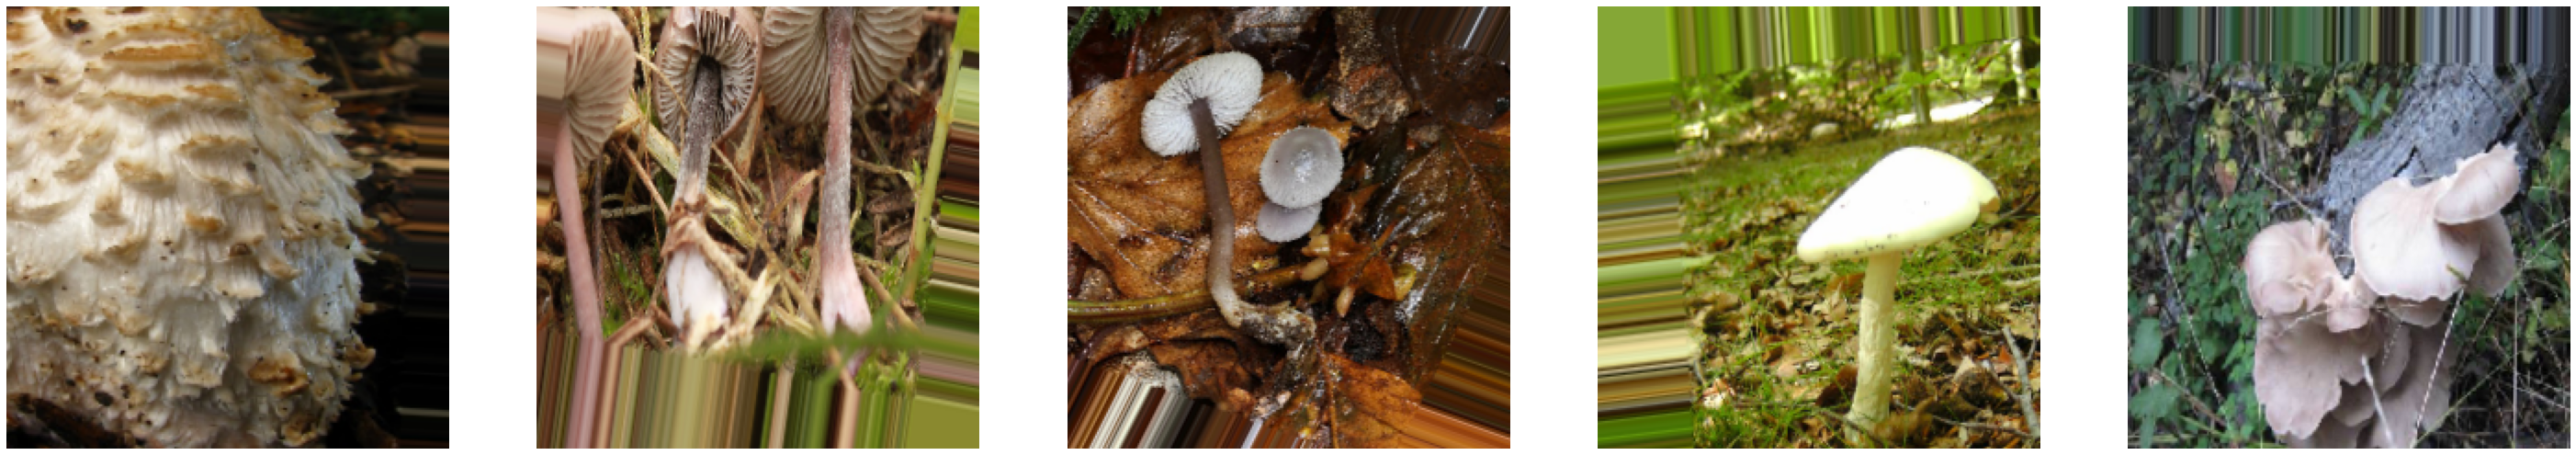

In [ ]:
plot_dataset = train_validation_datagen.flow_from_directory(
    TRAIN_DATASET_PATH, 
    target_size=IMG_SIZE, 
    class_mode='categorical', 
    batch_size=1,
    shuffle=True
)

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(50,50))

for i in range(5):
  image = next(plot_dataset)[0].astype('uint8')
  image = np.squeeze(image)

  ax[i].imshow(image)
  ax[i].axis('off')

### Model

*   EfficientNetB1, ktorý je trénovaný pomocou transfer learningu
*   Modelu boli odobraté posledné vrstvy pre klasifikovanie 1000 tried a bola mu pridaná Flatten vrstva a Dense vrstva so softmax funkciou pre klasifikovanie 16 tried húb



In [ ]:
b1 = EfficientNetB1(input_shape=(240, 240, 3), weights='imagenet', include_top=False, classifier_activation="softmax") 

In [ ]:
for layer in b1.layers:
    layer.trainable = False

In [ ]:
x = Flatten()(b1.output)

In [ ]:
prediction = Dense(16, activation='softmax')(x)

model = Model(inputs=b1.input, outputs=prediction)

In [ ]:
LAYERS_COUNT = len(model.layers)

print('Count of model layers: ', LAYERS_COUNT)

Count of model layers:  341


In [ ]:
model.layers

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
model.compile(
  loss='categorical_crossentropy',
  optimizer=tf.keras.optimizers.Adam(0.0003),
  metrics=['accuracy']
)

In [ ]:
model.summary()

In [ ]:
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)

In [ ]:
history = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=20,
  callbacks=[early_stop],
  batch_size=BATCH_SIZE)

Epoch 1/20
45/45 [==============================] - 104s 2s/step - loss: 1.3347 - accuracy: 0.6558 - val_loss: 0.4221 - val_accuracy: 0.8705
Epoch 2/20
45/45 [==============================] - 92s 2s/step - loss: 0.5021 - accuracy: 0.8564 - val_loss: 0.3500 - val_accuracy: 0.8871
Epoch 3/20
45/45 [==============================] - 92s 2s/step - loss: 0.4061 - accuracy: 0.8887 - val_loss: 0.2514 - val_accuracy: 0.9284
Epoch 4/20
45/45 [==============================] - 94s 2s/step - loss: 0.3333 - accuracy: 0.9152 - val_loss: 0.2727 - val_accuracy: 0.9091
Epoch 5/20
45/45 [==============================] - 93s 2s/step - loss: 0.3092 - accuracy: 0.9190 - val_loss: 0.3828 - val_accuracy: 0.9036
Epoch 6/20
45/45 [==============================] - 93s 2s/step - loss: 0.3059 - accuracy: 0.9197 - val_loss: 0.2441 - val_accuracy: 0.9201
Epoch 7/20
45/45 [==============================] - 93s 2s/step - loss: 0.2702 - accuracy: 0.9353 - val_loss: 0.2571 - val_accuracy: 0.9311
Epoch 8/20
45/45 [=

# Vykreslenie grafov hodnôt presnosti a stratovej funkcie

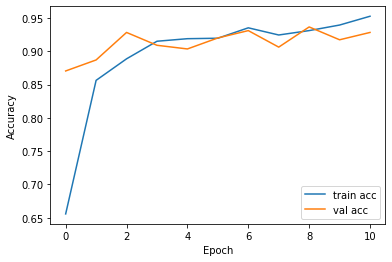

In [ ]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

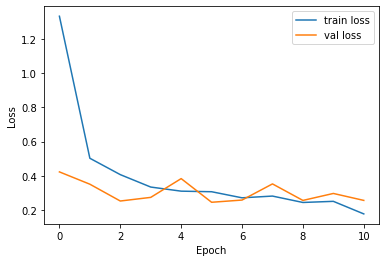

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluácia vytrénovaného modelu

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset,batch_size=BATCH_SIZE)

6/6 [==============================] - 6s 843ms/step - loss: 0.1912 - accuracy: 0.9477


In [ ]:
print("Testovacia loss {0:.2f}, Testovacia accuracy {1:.2f}%".format(test_loss, test_accuracy * 100))

Testovacia loss 0.19, Testovacia accuracy 94.77%


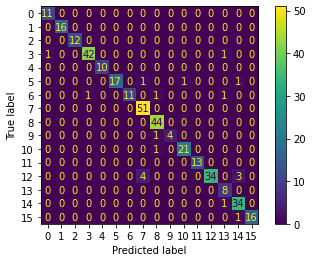

In [ ]:
Y_true_classes = test_dataset.classes
Y_predict = model.predict(test_dataset)

Y_pred_classes = np.argmax(Y_predict, axis=1)

CONFUSION_MATRIX = confusion_matrix(Y_true_classes, Y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=CONFUSION_MATRIX)

disp = disp.plot()

In [ ]:
print(classification_report(Y_true_classes, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       1.00      1.00      1.00        16
           2       1.00      1.00      1.00        12
           3       0.98      0.95      0.97        44
           4       1.00      1.00      1.00        10
           5       1.00      0.85      0.92        20
           6       1.00      0.79      0.88        14
           7       0.91      1.00      0.95        51
           8       0.94      1.00      0.97        44
           9       1.00      0.80      0.89         5
          10       0.95      0.95      0.95        22
          11       1.00      1.00      1.00        13
          12       1.00      0.83      0.91        41
          13       0.73      1.00      0.84         8
          14       0.87      0.97      0.92        35
          15       1.00      0.94      0.97        17

    accuracy                           0.95       363
   macro avg       0.96   

# Uloženie modelu

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/models/model_EfficientNetB1_acc96_valacc92_testacc95.h5') 

# Načítanie uloženého modelu

In [ ]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/models/model_EfficientNetB1_acc96_valacc92_testacc95.h5')

In [ ]:
loaded_model.summary()

In [ ]:
loss, acc = loaded_model.evaluate(test_dataset)
print("Načítaný model, loss {0:.2f}, accuracy {1:.2f}%".format(loss, acc * 100))

6/6 [==============================] - 19s 985ms/step - loss: 0.1912 - accuracy: 0.9477
Načítaný model, loss 0.19, accuracy 94.77%


Testovanie načítaného modelu

In [ ]:
def predict_and_evaluate():
  #test_data_batch = np.array(test_dataset)
  #print(test_data_batch.shape)

  predictions = loaded_model.predict(test_dataset)
  predicted_labels = np.argmax(predictions, axis=1)

  labels = test_dataset.classes
  class_indices = test_dataset.class_indices
  class_names = list(class_indices.keys())

  hits = 0

  for predicted_label, prediction, label in zip(predicted_labels, predictions, labels):
    probability = np.max(prediction) * 100
    print(
        '{} with {:.2f}% probability (real class: {})'.format(
            class_names[predicted_label],
            probability,
            class_names[label]
        )
    )

    hits = hits + 1 if label == predicted_label else hits

  accuracy = (hits / len(labels)) * 100
  return accuracy, predicted_labels

predict_and_evaluate()


E_Amanita_crocea with 99.64% probability (real class: E_Amanita_crocea)
E_Amanita_crocea with 99.46% probability (real class: E_Amanita_crocea)
E_Amanita_crocea with 99.98% probability (real class: E_Amanita_crocea)
E_Amanita_crocea with 81.92% probability (real class: E_Amanita_crocea)
E_Amanita_crocea with 100.00% probability (real class: E_Amanita_crocea)
E_Amanita_crocea with 97.72% probability (real class: E_Amanita_crocea)
E_Amanita_crocea with 99.92% probability (real class: E_Amanita_crocea)
E_Amanita_crocea with 100.00% probability (real class: E_Amanita_crocea)
E_Amanita_crocea with 99.20% probability (real class: E_Amanita_crocea)
E_Amanita_crocea with 99.62% probability (real class: E_Amanita_crocea)
E_Amanita_crocea with 96.77% probability (real class: E_Amanita_crocea)
E_Boletus_reticulatus with 99.98% probability (real class: E_Boletus_reticulatus)
E_Boletus_reticulatus with 100.00% probability (real class: E_Boletus_reticulatus)
E_Boletus_reticulatus with 99.99% probabi

(94.76584022038568,
 array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  3,  3,  3, 13,  3,  3,  3,  3,  3,  3,  0,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5, 14,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5, 10,  5,  5,  5,  7,  8,  6,  6,  6,  6,  6,
         3,  6,  6,  6,  6, 13,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,
         7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
         7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
         7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, 